<h3><center>This Jupyter Notebook analyzes GLM (Geostationary Lightning Mapper) using out of the box GP tools within the ArcGIS Platform <center></h3> 
    
Shown within this notebook, this workflow using out-of-the-box geoprocessing tools can be automated and visualized using the ArcPy Module and the ArcGIS Python API. 


This script reads in GLM netcdf files (group) to a feature layers containing point locations of "groups". These group data are aggregated into 5 minute interval layers and assigned timestamps. Using the Group Density tool within the Geoanalytics Server to calculate the density of these group GLM points, a final product lighting density layer is produced. Finally, we can access and view the results stored within the portal using the Python API. 



<h2><center> Calling the ArcGIS API by importing the <a href="https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html">GIS Module</a> and loading ArcPy</center></h2>


In [1]:
from arcgis.gis import GIS
import arcpy
import re
import datetime
import glob
import os 
print(os.getcwd())

C:\Users\lu9739


### Define the path to the GLM netCDF files. A NetCDF filetype contains multidimentional data, mostly used to store climate and weather data.


#### About GLM Product

![GLM](http://goesrglm.weebly.com/uploads/1/5/1/8/15188078/7207434_orig.jpg?1 == 150px)

Goodman et. al, 2010


In [2]:
#Define the folder path to netcdf files
glm_folder = r"C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\SampleGLMData"

arcpy.env.overwriteOutput = True
cdfList = glob.glob('{}\\*nc'.format(glm_folder))  


for file in cdfList[-4:]:
    print(file)    

C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\SampleGLMData\OR_GLM-L2-LCFA_G16_s20181342006200_e20181342006400_c20181342006414.nc
C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\SampleGLMData\OR_GLM-L2-LCFA_G16_s20181342006400_e20181342007000_c20181342007026.nc
C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\SampleGLMData\OR_GLM-L2-LCFA_G16_s20181342007000_e20181342007200_c20181342007232.nc
C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\SampleGLMData\OR_GLM-L2-LCFA_G16_s20181342007200_e20181342007400_c20181342007428.nc


<h2><center> Turns each GLM netCDF file into feature layers containing the point locations of "group" point locations. (Using the "Make NetCDF Feature Layer" tool)</center></h2>

The resulting netCDF feature layer can be used as input to any geoprocessing tool that accepts a feature class as input.

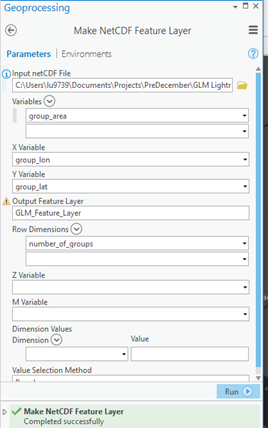

In [3]:
#Turns each NetCDF file to feature class points
fc_gdb = r"C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\IndividualGLMFC.gdb"

i = 0 
alist = list(range(10000))

num_limit = 13 

for cdf in cdfList:
	##Execute the NetCDF to feature layer tool 
	featname = str(alist[i])  + cdf

	cdf_list = featname.split("_")
	timeinfo = cdf_list[5]
	year = timeinfo[1:5]
	julianday = timeinfo[5:8]
	hour = timeinfo[8:10]
	minute = timeinfo[10:12]
	sec = timeinfo[12:14]


	#Makes feature layer from Netcdf and assigns it to a value 
	fl = arcpy.MakeNetCDFFeatureLayer_md(cdf,'group_area','group_lon','group_lat','{}\\{}'.format(fc_gdb,featname),'number_of_groups').getOutput(0)

	#Turns feature layer to feature class
	#Naming convention: GLMData_YYYY (Time stamp is measured in zulu time)
	f2 = arcpy.CopyFeatures_management(fl, '{}\\GLMData_{}{}{}{}{}'.format(fc_gdb, year,julianday,hour,minute,sec))

	i =  i + 1
	print("{} files out of {} processed".format(i, len(cdfList)))

1 files out of 23 processed
2 files out of 23 processed
3 files out of 23 processed
4 files out of 23 processed
5 files out of 23 processed
6 files out of 23 processed
7 files out of 23 processed
8 files out of 23 processed
9 files out of 23 processed
10 files out of 23 processed
11 files out of 23 processed
12 files out of 23 processed
13 files out of 23 processed
14 files out of 23 processed
15 files out of 23 processed
16 files out of 23 processed
17 files out of 23 processed
18 files out of 23 processed
19 files out of 23 processed
20 files out of 23 processed
21 files out of 23 processed
22 files out of 23 processed
23 files out of 23 processed


<h2><center> Using the Merge GP tool, Aggregates each 20 second GLM feature class to rolling 5 minute layers (for every minute). </center></h2> 


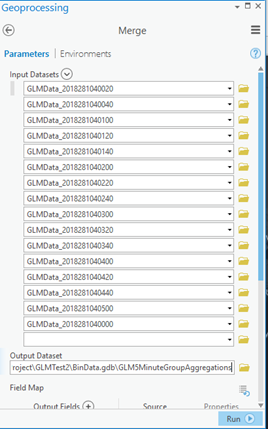

In [9]:
#Makes 5 minute aggregations of GLM Point Density
fc_gdb = r"C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\IndividualGLMFC.gdb"

arcpy.env.workspace = fc_gdb
arcpy.env.overwriteOutput = True

agg_gdb = r"C:\Users\lu9739\Documents\Projects\2018\GLM Lightning Project\GLMTest2\AggData.gdb"


#Obtains list of the (all) feature class point data from the GLM2 Database 
fclist = arcpy.ListFeatureClasses()


#Loop that makes a 5 minute aggregate fc with 1 min update, also give names to each outfile
fc_index = 7 
i = 0


numAgg = int((len(fclist))) 
#print(numAgg)

while (fc_index + 7 < numAgg):

	year = fclist[fc_index][8:12]
	julianday = fclist[fc_index][12:15]
	hour = fclist[fc_index][15:17]
	minute = fclist[fc_index][17:19]
	sec = fclist[fc_index][19:]

	in_list = [fclist[fc_index - 7],fclist[fc_index - 6],fclist[fc_index - 5],fclist[fc_index - 4],fclist[fc_index - 3],fclist[fc_index - 2],fclist[fc_index - 1],fclist[fc_index],fclist[fc_index + 1],fclist[fc_index + 2],fclist[fc_index + 3],fclist[fc_index + 4],fclist[fc_index + 5],fclist[fc_index + 6],fclist[fc_index + 7]]

	arcpy.Merge_management(in_list, "{}\\Agg5min{}{}{}{}{}".format(agg_gdb, year,julianday,hour,minute,sec))
	print("{}{}{}{}{} aggregated".format(year,julianday,hour,minute,sec))
	fc_index = fc_index + 3 
        

### Adds timestamps to each aggregate file layer


<img src="Pictures/glmworkflow.png" alt="Italian Trulli">
<br>
<br>

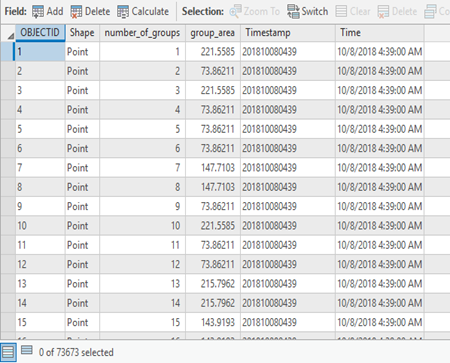


In [ ]:
#Adds timestamps to each 5 minute feature class 
arcpy.env.workspace = agg_gdb

agglist = arcpy.ListFeatureClasses()

for fc5 in agglist:


	#Get the time fields 
	yearday = fc5[9:14]

	date = datetime.datetime.strptime(yearday, '%y%j').date()
	datemonth = str(date)

	year = str(datemonth[:4])
	month = str(datemonth[5:7])
	date = str(datemonth[8:])
	hour = str(fc5[14:16])
	minute = str(fc5[16:18])

	time = year + month + date + hour + minute
	arcpy.AddMessage(time)

	#Add 'unfinished' time field as a number 
	arcpy.AddField_management(fc5, "Timestamp",'TEXT', None , None, None, None, "NULLABLE", "NON_REQUIRED", None)
	arcpy.AddMessage("Field Added")


	#Assigning values to each row 
	cur = arcpy.UpdateCursor(fc5)

	for row in cur: 
		row.setValue('Timestamp', "{}".format(time))
		cur.updateRow(row)


	arcpy.ConvertTimeField_management(fc5, "Timestamp", "yyyyMMddHHmm",'Time', 'DATE')

<h3><center> Call the Group Density tool within the Geoanalytics Server to calculate the density of these group GLM points, this produces a lighting density layer. The GeoAnalytics Server introduces distributed computing to vector-based feature data to quickly analyze large volumes of data.</center></h3>


<img src="Pictures/gptools.png" alt="Geoanalytic Server">


- Distributed computing to vector-based feature data
- Analyze big data 
- Accelerate traditional ArcGIS Desktop analysis workflows.


In [ ]:
#Push the features to a geoanalytic server to create a density product 
arcpy.env.workspace = agg_gdb
arcpy.env.overwriteOutput = True

aglist = arcpy.ListFeatureClasses()


#By lightning area
counter = 1 
binSize = '4 Kilometers'
neighborhoodSize = '4.51 Kilometers'
fields = "group_area"
time  = "Time"


for fc1 in aglist:
	fc2 = "density1" + fc1 
	arcpy.geoanalytics.CalculateDensity(fc1, "GLM_FedGIS1", 'SQUARE', binSize, 'KERNEL', neighborhoodSize, fields ,'SQUARE_KILOMETERS', None, None, None , 'SPATIOTEMPORAL_DATA_STORE')
	counter = counter + 1 
	arcpy.AddMessage("{} uploaded to Portal".format(fc2))

### Log into the Portal using the Python API to map the layer we created 

In [6]:
#Now the product is in a server environment, we will now use the ArcGIS API for Python 
gis = GIS("https://wdcsol000016.esri.com/portal", "lu9739@AVWORLD")


Enter password: ········



<center><h2> Using the Python API functions, we can search for the GLM Data Product that is stored within our Portal </h2></center>

In [7]:
#Search for our item 
search_result = gis.content.search(query="title:GLM_FedGIS", item_type="Feature Layer")
GLM_layer = search_result[0]

glm_fl = GLM_layer.layers
glm_fl

[<FeatureLayer url:"https://WDCSOL000016.ESRI.COM/server/rest/services/Hosted/GLM_FedGIS/FeatureServer/0">]

In [8]:
#Make a map containing the data 
m1 = GIS().map("Cumberland, MD", zoomlevel = 7)
m1.add_layer(GLM_layer)
m1

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…